### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Loading data files into data frames

In [2]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
orders = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")
order_products_prior = pd.read_csv("data/order_products__prior.csv")
order_products_train = pd.read_csv("data/order_products__train.csv")

#### Converting categorical variables into category data type

In [3]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders_merged = orders.merge(order_products_prior, on='order_id', how='inner')
orders_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [6]:
orders_merged.eval_set.value_counts()

prior    32434489
test            0
train           0
Name: eval_set, dtype: int64

In [7]:
# Merging user id with order_number in order to find number of orders for each user
users = orders_merged.groupby('user_id')['order_number'].max().to_frame('user_orders').reset_index()

users.head()

,user_id,user_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [8]:
# Merging product id with order id in order to find number of orders for each product
prod = orders_merged.groupby('product_id')['order_id'].count().to_frame('prod_purchases').reset_index()

prod.head()

,product_id,prod_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [9]:
# Merging user id, product id with order id in order to find number of orders
uxp = orders_merged.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_t_bought').reset_index()

uxp.head()

,user_id,product_id,uxp_t_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [10]:
data = uxp.merge(users, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_t_bought,user_orders
0,1,196,10,10
1,1,10258,9,10
2,1,10326,1,10
3,1,12427,10,10
4,1,13032,3,10


In [11]:
data = data.merge(prod, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_t_bought,user_orders,prod_purchases
0,1,196,10,10,35791
1,1,10258,9,10,1946
2,1,10326,1,10,5526
3,1,12427,10,10,6476
4,1,13032,3,10,3751


In [12]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [13]:
orders_future = orders[((orders['eval_set']=='train') | (orders['eval_set']=='test'))]
orders_future = orders_future[['user_id', 'eval_set', 'order_id'] ]
orders_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [14]:
data = data.merge(orders_future, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_t_bought,user_orders,prod_purchases,eval_set,order_id
0,1,196,10,10,35791,train,1187899
1,1,10258,9,10,1946,train,1187899
2,1,10326,1,10,5526,train,1187899
3,1,12427,10,10,6476,train,1187899
4,1,13032,3,10,3751,train,1187899


#### Retrieving only the train data 

In [15]:
train = data[data['eval_set']=='train']
train = train.merge(order_products_train[['product_id','order_id', 'reordered']], 
                    on=['product_id','order_id'], how='left' )
train['reordered'] = train['reordered'].fillna(0)
train.head()

,user_id,product_id,uxp_t_bought,user_orders,prod_purchases,eval_set,order_id,reordered
0,1,196,10,10,35791,train,1187899,1.0
1,1,10258,9,10,1946,train,1187899,1.0
2,1,10326,1,10,5526,train,1187899,0.0
3,1,12427,10,10,6476,train,1187899,0.0
4,1,13032,3,10,3751,train,1187899,1.0


In [16]:
train = train.set_index(['user_id', 'product_id'])
train.head(15)

uxp_t_bought  user_orders  prod_purchases eval_set  \
user_id product_id                                                       
1       196                   10           10           35791    train   
        10258                  9           10            1946    train   
        10326                  1           10            5526    train   
        12427                 10           10            6476    train   
        13032                  3           10            3751    train   
        13176                  2           10          379450    train   
        14084                  1           10           15935    train   
        17122                  1           10           13880    train   
        25133                  8           10            6196    train   
        26088                  2           10            2523    train   
        26405                  2           10            1214    train   
        30450                  1           10           21490    train   
        35951                  1           10           57895    train   
        38928                  1           10           13238    train   
        39657                  1           10            5019    train   

                    order_id  reordered  
user_id product_id                       
1       196          1187899        1.0  
        10258        1187899        1.0  
        10326        1187899        0.0  
        12427        1187899        0.0  
        13032        1187899        1.0  
        13176        1187899        0.0  
        14084        1187899        0.0  
        17122        1187899        0.0  
        25133        1187899        1.0  
        26088        1187899        1.0  
        26405        1187899        1.0  
        30450        1187899        0.0  
        35951        1187899        0.0  
        38928        1187899        1.0  
        39657        1187899        1.0

In [17]:
train = train.drop(['eval_set', 'order_id'], axis=1)
train.head(15)

uxp_t_bought  user_orders  prod_purchases  reordered
user_id product_id                                                      
1       196                   10           10           35791        1.0
        10258                  9           10            1946        1.0
        10326                  1           10            5526        0.0
        12427                 10           10            6476        0.0
        13032                  3           10            3751        1.0
        13176                  2           10          379450        0.0
        14084                  1           10           15935        0.0
        17122                  1           10           13880        0.0
        25133                  8           10            6196        1.0
        26088                  2           10            2523        1.0
        26405                  2           10            1214        1.0
        30450                  1           10           21490        0.0
        35951                  1           10           57895        0.0
        38928                  1           10           13238        1.0
        39657                  1           10            5019        1.0

#### Accessing the test data

In [18]:
test = data[data['eval_set']=='test'] 
test = test.set_index(['user_id', 'product_id']) 
test.head(40)

uxp_t_bought  user_orders  prod_purchases eval_set  \
user_id product_id                                                       
3       248                    1           12            6371     test   
        1005                   1           12             463     test   
        1819                   3           12            2424     test   
        7503                   1           12           12474     test   
        8021                   1           12           27864     test   
        9387                   5           12           36187     test   
        12845                  1           12           10027     test   
        14992                  2           12           29069     test   
        15143                  1           12            3447     test   
        16797                  3           12          142951     test   
        16965                  2           12           13273     test   
        17668                  5           12            2110     test   
        18370                  1           12           18449     test   
        18599                  4           12            6204     test   
        21137                  1           12          264683     test   
        21903                  8           12          241921     test   
        22035                  3           12           59676     test   
        23650                  2           12            3164     test   
        24010                  2           12            6562     test   
        24810                  3           12            8357     test   
        28373                  2           12            7335     test   
        32402                  3           12            2056     test   
        38596                  1           12            3948     test   
        39190                 10           12           10972     test   
        39922                  1           12            7393     test   
        40604                  1           12           32351     test   
        42265                  1           12           76896     test   
        42557                  1           12            8324     test   
        43961                  4           12           55371     test   
        44683                  2           12           22275     test   
        47766                  9           12          176815     test   
        48523                  2           12            5129     test   
        49683                  1           12           97315     test   
4       1200                   1            5             732     test   
        2707                   1            5            2349     test   
        7160                   1            5             214     test   
        7350                   1            5            3518     test   
        11865                  1            5            2419     test   
        17769                  1            5            1268     test   
        19057                  1            5           75165     test   

                    order_id  
user_id product_id            
3       248          2774568  
        1005         2774568  
        1819         2774568  
        7503         2774568  
        8021         2774568  
        9387         2774568  
        12845        2774568  
        14992        2774568  
        15143        2774568  
        16797        2774568  
        16965        2774568  
        17668        2774568  
        18370        2774568  
        18599        2774568  
        21137        2774568  
        21903        2774568  
        22035        2774568  
        23650        2774568  
        24010        2774568  
        24810        2774568  
        28373        2774568  
        32402        2774568  
        38596        2774568  
        39190        2774568  
        39922        2774568  
        40604        2774568  
        42265        2774568  
        4255

In [19]:
test = test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
test.head()

uxp_t_bought  user_orders  prod_purchases
user_id product_id                                           
3       248                    1           12            6371
        1005                   1           12             463
        1819                   3           12            2424
        7503                   1           12           12474
        8021                   1           12           27864

### Applying models

#### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

X_train, y_train = train.drop('reordered', axis=1), train.reordered

tree = DecisionTreeClassifier(random_state=42)
model = tree.fit(X_train, y_train)

In [21]:
test_pred = model.predict(test).astype(int)
test_pred[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [22]:
test_pred = (model.predict_proba(test)[:,1] >= 0.21).astype(int)
test_pred[0:30]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0])

In [23]:
test['prediction'] = test_pred
test.head()

uxp_t_bought  user_orders  prod_purchases  prediction
user_id product_id                                                       
3       248                    1           12            6371           0
        1005                   1           12             463           0
        1819                   3           12            2424           1
        7503                   1           12           12474           0
        8021                   1           12           27864           0

In [24]:
test['prediction'].value_counts()

0    4250142
1     583150
Name: prediction, dtype: int64

In [25]:
final = test.reset_index()
#Keep only the required columns 
final = final[['product_id', 'user_id', 'prediction']]

final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,1
3,7503,3,0
4,8021,3,0


In [26]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [27]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,1,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


#### Dropping the prediction column as to run the model on the data 

In [28]:
test1 = test.drop('prediction',axis=1)
test1.head()

uxp_t_bought  user_orders  prod_purchases
user_id product_id                                           
3       248                    1           12            6371
        1005                   1           12             463
        1819                   3           12            2424
        7503                   1           12           12474
        8021                   1           12           27864

#### Applying Logistic Regression model

In [29]:
from sklearn.linear_model import LogisticRegression

X_train, y_train = train.drop('reordered', axis=1), train.reordered

log = LogisticRegression(random_state=42)
model1 = log.fit(X_train, y_train)

In [30]:
test_pred_log = model1.predict(test1).astype(int)
test_pred_log[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
test_pred_log = (model1.predict_proba(test1)[:,1] >= 0.21).astype(int)
test_pred_log[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [32]:
test1['prediction'] = test_pred_log
test1.head()

uxp_t_bought  user_orders  prod_purchases  prediction
user_id product_id                                                       
3       248                    1           12            6371           0
        1005                   1           12             463           0
        1819                   3           12            2424           0
        7503                   1           12           12474           0
        8021                   1           12           27864           0

#### We can observe the predictions values difference from the above model

In [33]:
test1['prediction'].value_counts()

0    4566594
1     266698
Name: prediction, dtype: int64

In [34]:
final1 = test1.reset_index()
#Keep only the required columns 
final1 = final1[['product_id', 'user_id', 'prediction']]

final1.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [35]:
orders_test1 = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test1.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [36]:
final1 = final1.merge(orders_test, on='user_id', how='left')
final1.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


#### Dropping the prediction column again to run the model on data

In [37]:
test2 = test1.drop('prediction',axis=1)
test2.head()

uxp_t_bought  user_orders  prod_purchases
user_id product_id                                           
3       248                    1           12            6371
        1005                   1           12             463
        1819                   3           12            2424
        7503                   1           12           12474
        8021                   1           12           27864

#### Applying Naives Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

X_train, y_train = train.drop('reordered', axis=1), train.reordered
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [39]:
test_pred_nb = nb.predict(test2).astype(int)
test_pred_nb[0:30]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1])

In [40]:
test_pred_nb = (nb.predict_proba(test2)[:,1] >= 0.21).astype(int)
test_pred_nb[0:30]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1])

In [41]:
test2['prediction'] = test_pred_nb
test2.head()

uxp_t_bought  user_orders  prod_purchases  prediction
user_id product_id                                                       
3       248                    1           12            6371           0
        1005                   1           12             463           0
        1819                   3           12            2424           0
        7503                   1           12           12474           0
        8021                   1           12           27864           1

#### We can observe the predictions values difference from the other models

In [42]:
test2['prediction'].value_counts()

0    3771661
1    1061631
Name: prediction, dtype: int64

In [43]:
final2 = test2.reset_index()
#Keep only the required columns 
final2 = final2[['product_id', 'user_id', 'prediction']]

final2.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,1


In [44]:
orders_test2 = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test2.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [45]:
final2 = final2.merge(orders_test, on='user_id', how='left')
final2.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,1,2774568


#### The scores for the three models can be observed and we can say that decision tree is better for predicting our target variable

In [46]:
print("Decision tree score:"+str(tree.score(X_train, y_train)))
print("Logistic Regression score:"+str(log.score(X_train, y_train)))
print("Naive bayes score:"+str(nb.score(X_train, y_train)))

Decision tree score:0.9275779880752753
Logistic Regression score:0.9034088797180205
Naive bayes score:0.7668851886818836


#### Below is the roc curve of the three models

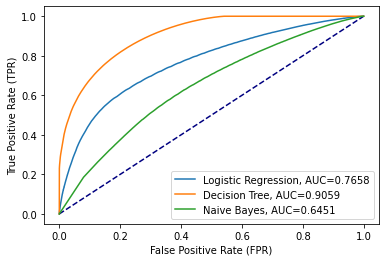

In [48]:
#set up plotting area
plt.figure(0).clf()
from sklearn.naive_bayes import MultinomialNB
#fit logistic regression model and plot ROC curve
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_train, y_pred,pos_label=1)
auc = round(metrics.roc_auc_score(y_train, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit decision tree model and plot ROC curve
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_train, y_pred,pos_label=1)
auc = round(metrics.roc_auc_score(y_train, y_pred), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#fit navie bayes model and plot ROC curve
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_train, y_pred,pos_label=1)
auc = round(metrics.roc_auc_score(y_train, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

# axis labels
pyplot.xlabel('False Positive Rate (FPR)')
pyplot.ylabel('True Positive Rate (TPR)')

#add legend
plt.legend()
